In [18]:
import numpy as np
import math
import scipy.stats as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import graphviz
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import time
import pickle

import ipywidgets as wg
import IPython
from IPython.display import HTML, display, clear_output

import scipy.integrate as integrate
#from scipy.spatial import cKDTree
#from scipy import interpolate
#from scipy.signal import argrelextrema

from decimal import Decimal

#from astropy import stats

import sys


# Ising model function definitions

In [19]:
def energy_calc(lattice):
    ''' Calculated total energy of the lattice.
    
        Parameters:
            lattice: [N,N] numpy array containing only 1 and -1 values representing the spin configuration.
        
        Returns: dtype float
            Energy of the spin configuration'''
    
    a = lattice[:,1:]*lattice[:,:N-1]
    b = lattice[:N-1,:]*lattice[1:,:]
    # To ensure periodic boundary conditions the last column is multiplied with the first column of the lattice array. 
    # Same is done with the rows.
    c = lattice[0]*lattice[N-1]
    d = lattice[:,0]*lattice[:,N-1]
    # Energy:
    E = -1*(np.sum(a)+np.sum(b)+np.sum(c)+np.sum(d))
    return(E)

In [20]:
def energy_nn(lattice,x,y):
    ''' Calculate nearest neighbour interaction energy of 1 spin in the lattice.
    
        Parameters:
            lattice: dtype numpy array
                [N,N] numpy array containing only 1 and -1 values representing the spin configuration.
            
            x, y: dtype int
                The coordinates of the of the spin of interest
        
        Returns: dtype float
             nearest neighbour interaction energy of the selected spin '''
    
    s = lattice[x,y]
    nn = lattice[(x+1)%N,y] + lattice[(x-1)%N,y] + lattice[x,(y+1)%N] + lattice[x,(y-1)%N]
    E = -1*nn*s
    return(E)

In [21]:
def specific_heat(x):
    ''' Calculates specific heat.
        
        Parameters: 
            x: dtype numpy array
                One dimensional array containing the energy data (or equivalent quantity)
            
        Returns: dtype numpy array
            One dimensional array containing the specific heat data'''
    
    cv = (np.var(x, axis=0))/(T**2)
    return(cv)

In [22]:
def susceptiblity(mag):
    ''' Calculates specific heat.
        
        Parameters: 
            mag: dtype numpy array
                One dimensional array containing the magnetization data
            
        Returns: dtype numpy array
            One dimensional array containing the susceptibility data'''
    
    susc = (np.var(mag))/T
    return(susc)

In [23]:
def metropolis(lattice,E,M):
    ''' Implement metropolis algorithm for a single spin flip.
    
        Parameters: 
            lattice: dtype numpy array
                [N,N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L^2):
    x = np.random.randint(0,N)
    y = np.random.randint(0,N)
    trial_lattice = np.copy(lattice)
    trial_lattice[x,y] *= -1
    # Calculate energy difference between the old and trial configurations:
    dE = energy_nn(trial_lattice,x,y) - energy_nn(lattice,x,y)
    # Implement second stage of the metropolis algorithm:
    if dE <= 0:
        E = E + dE
        M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
        lattice[x,y] = trial_lattice[x,y]
    else:
        r = np.random.uniform(0,1)
        #p=np.exp(-dE/tau)
        if dE == 4:
            p = exp[1]
        else:
            p = exp[0]
        if r < p:
            E = E + dE
            M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
            lattice[x,y] = trial_lattice[x,y]
    return(lattice,E,M)

In [24]:
def Wolffbacktrack(x,y,cluster,visited):
    ''' Part of the Wolff algorithm, it checks whether a spin is already in the cluster'''
    if cluster[x,y]:
        return False
    if visited[x,y]:
        return True#False
    return True

def grow_cluster(lattice,x,y,ClusterSpin,E,M, cluster,visited):
    """ Starting from a randomly chosen spin, creates a cluster with the Wolff Algorithm.
        
        Parameters:
            lattice: dtype numpy array
                The [N,N] array representing the spin configuration
            
            x, and y: dtype int
                The coordinates of the spin that is added to the cluster
                
            ClusterSpin: dtype int
                The spin value of the cluster
            
            E and M: dtype int or float
                The energy and magnetization of the lattice
            
            cluster: dtype boolean numpy array
                [N,N] boolean numpy array indicating which spins are in the cluster
                
            visited: dtype boolean numpy array
                [N,N] boolean numpy array indicating which spins have already been trialed by the algorithm
                
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization"""
    
    old_E = energy_nn(lattice,x,y)
    lattice[x,y] *=-1
    dE = energy_nn(lattice,x,y) - old_E
    E = E + dE
    M = M - lattice[x,y]*-1 +lattice[x,y]
    #cluster.append([x,y])
    cluster[x,y] = True
    if Wolffbacktrack((x+1)%N,y, cluster, visited):
        E, M = try_add(lattice,(x+1)%N,y,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack((x-1)%N,y, cluster,visited):
        E, M = try_add(lattice,(x-1)%N,y,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack(x,(y+1)%N, cluster,visited):
        E, M = try_add(lattice,x,(y+1)%N,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack(x,(y-1)%N, cluster,visited):
        E, M = try_add(lattice,x,(y-1)%N,ClusterSpin,E,M, cluster,visited)
    return(lattice,E,M)

def try_add(lattice,x,y,ClusterSpin,E,M, cluster, visited):
    """Checks of neighbor belongs to cluster, if so then add neighbor to cluster with a certain probability"""
    
    s_help = lattice[x,y]
    #global tau
    if ((s_help<0) != (ClusterSpin<0)):
        r = np.random.uniform(0,1)
        if r < (1-A_wolff):
            lattice, E, M = grow_cluster(lattice,x,y,ClusterSpin,E,M, cluster,visited)
        else:
            visited[x,y] = True
    return(E,M)

def Wolff(lattice,E,M):
    ''' Implements the wolff algorithm for a single timestep.
        
        Parameters: 
            lattice: dtype numpy array
                [N,N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    x = np.random.randint(0,N)
    y = np.random.randint(0,N)
    cluster = np.full((N,N), False, dtype=bool)
    visited = np.full((N,N), False, dtype=bool)
    clusterspin = lattice[x,y]*-1
    lattice, E, M = grow_cluster(lattice,x,y,clusterspin, E, M, cluster,visited)
    return(lattice,E,M)

# Correspondence function definitions

In [25]:
def network_energy_calc(N_edges, N_l):
    # N_l is the total number of possible cross-edges (possible nn interactions)
    nwEl = (2*N_edges)-(N_l)
    return(nwEl)

In [26]:
def number_of_RGsteps(n):
    tel = 0
    neG_baseline = n**2-1
    lat_size = n
    while n > 1:
        if n%2 != 0:
            raise ValueError("%d is not a power of the blocking size 2"%(lat_size))
        tel += 1
        n = n/2
        neG_baseline += n**2
    return (tel, neG_baseline)

In [27]:
def RGlats_skeleton():
    """ Creates the 'bare' shells of the RGb graph. That is, a list of spin lattices of decreasing size in accordance with the 
        branching factor 2, that serve as 'skeleton lattices' that can be modified by the RGb procedure
        
        Returns: 
            lats: dtype list
                list of lattice arrays. They serve as the initial spin lattices that constitute the shells of the RGb graph
    """
    lats = []; lats.append(np.zeros((N,N)))
    n = N # length of shell
    while n > 1:
        n //= 2
        new_lat = np.zeros((n,n))
        lats.append(new_lat)
    return(lats)

In [28]:
def boundary_pos():
    """ Part of RGgraph_skeleton. Creates dictionary, which labels the spins of lattice (assigning a number from 0 to N^2) and 
        registers their position in the lattice
        
        Returns:
            pos: dtype dictionary
                dictionary of (boundary) spins which registers their position in the lattice
    """
    tel = 0
    pos = {i: [] for i in range(N**2)}
    for j in range(N):
        for i in range(N):
            pos[tel] = [i,j,0]
            tel += 1
    return(pos)

In [29]:
def RGgraph_skeleton():
    """ Creates boundary graph (collection of nodes) corresponding to the spin lattice, and the 'bare' tree graph
        
        Returns:
            bulkG: dtype networkx multigraph
                'bare' tree graph, i.e. the boundary + bulk tree graph that serves as a skeleton for the RGb graph
                
            pos: dtype dictionary
                extended boundary position dictionary to a dictionary of all the nodes/spins of the network, i.e. all 
                nodes/spins of the network are labeled by a number and the dictionary registers their (3D) position in space
            
            lats_idx: dtype list
                list of arrays that contain the node/spin labels fo each shell lattice similar to the position dictionary. 
    """
    shell = 0; dz =1
    n = N; new_n = n
    pos = boundary_pos()
    lats_idx = []
    
    # Boundary graph
    bdG = nx.MultiGraph()
    for i in range(N**2):
        bdG.add_node(i)
    # Bulk graph
    bulkG = bdG.copy()
    lat_idx = np.arange(N**2).reshape(N,N)#np.transpose(np.arange(N**2).reshape(N,N))
    lats_idx.append(lat_idx)
    #print(lat_idx)
    
    while n > 1:
        new_n //= 2
        new_lat_idx = np.zeros((new_n,new_n))
        for i in np.arange(0,n,2):
            for j in np.arange(0,n,2):
                n_Gr = nx.number_of_nodes(bulkG); bulkG.add_node(n_Gr)
                block = lat_idx[i:i+2,j:j+2].reshape(4)
                new_pos = []
                for k in block:
                    bulkG.add_edge(n_Gr,k)
                    new_pos.append(pos[k])
                new_lat_idx[i//2,j//2] = n_Gr
                new_pos = list(np.round(np.mean(np.array(new_pos),axis=0),1))
                new_pos[2] = (shell+1)*dz
                pos.update({n_Gr: new_pos})
        lat_idx = np.transpose(new_lat_idx)
        lats_idx.append(lat_idx)
        n = new_n
        shell += 1
        #print(lat_idx)
        
    return(bulkG, pos, lats_idx)

In [30]:
def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N,N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map_x: dtype numpy array
                [N,N] boolean array containing True if nn bond is present in the x-direction (horizontal), or False if not.
                
            f_map_y: dtype numpy array
                [N,N] boolean array containing True if nn bond is present in the y-direction (vertical), or False if not.
    """
    lat = np.array(lat)
    a = lat[:,1:]-lat[:,:-1]; b = lat[:,0]-lat[:,-1]
    b = np.reshape(b,(len(lat),1))
    c = np.append(a,b,axis=1)
    f_map_y = (c == 0)
    # same for y
    a = lat[1:]-lat[:-1]; b = lat[0]-lat[-1]
    b = np.reshape(b,(1,len(lat)))
    c = np.append(a,b,axis=0)
    f_map_x = (c == 0)
    return(f_map_x, f_map_y)

In [31]:
def construct_graph(lat, lats, lats_idx, Gr):
    """ Construct graph from spin lattice according to the RGb procedure
        
        Input: 
            lat: dtype numpy array
                [N,N] array containing only 1 and -1 values representing the spin configuration
            
            lats: dtype list
                list containing the initial spin lattices that constitutes the shells of the graph (i.e. as constructed by the 
                function 'RGlats_skeleton')
                
            lats_idx: dtype list
                list of arrays that contain the node/spin labels of the spin lattices (shells)
            
            Gr: dtype networkx multigraph
                'bare' tree graph that serves as the 'skeleton' for the RGb graph (i.e. as constructed by the function 
                'RGgraph_skeleton')
            
        Returns: 
            Gr: dtype networkx multigraph
                RGb graph
    """
    n = N; shell = 0
    Gr = Gr.copy()
    while shell < len(lats):
        lats[shell] = lat
        if shell == (len(lats)-1):
            break
        # Update RG graph accordingly:
        frmx, frmy = create_frozen_map(lat)
        idx = np.where(frmx==False)
        for i,j in zip(idx[0], idx[1]):
            k = lats_idx[shell][i,j]
            l = lats_idx[shell][(i+1)%n,j]
            Gr.add_edge(k,l)
        idx = np.where(frmy==False)
        for i,j in zip(idx[0], idx[1]):
            k = lats_idx[shell][i,j]
            l = lats_idx[shell][i,(j+1)%n]
            Gr.add_edge(k,l) 
        # Do RG step:
        old_lat = lat
        n //= 2
        lat = lat.reshape(n,2,n,2) 
        lat = lat.sum(axis=(1,3))
        idx_zeros = np.where(lat==0)
        old_idx_zeros = tuple([2*i for i in idx_zeros])
        lat[idx_zeros] = old_lat[old_idx_zeros] #np.random.choice([1,-1], size=len(idx_zeros[1]))
        lat = lat/abs(lat)
        
        shell += 1
    return(Gr)

In [32]:
def construct_graph_eff(lat, n_shells):
    n = N; shell = 0
    neGr = np.zeros(n_shells)
    NWen = np.zeros(n_shells)
    while shell < n_shells:
        # Update RG graph accordingly:
        frmx, frmy = create_frozen_map(lat)
        idx = np.where(frmx==False)
        N_edges_x = len(idx[0])
        idx = np.where(frmy==False)
        N_edges_y = len(idx[0])
        neGr[shell] = N_edges_x + N_edges_y
        # Calculate network energy
        NWen[shell] = network_energy_calc(neGr[shell], 2*(n**2))
        # Do RG step:
        old_lat = lat
        n //= 2
        lat = lat.reshape(n,2,n,2) 
        lat = lat.sum(axis=(1,3))
        idx_zeros = np.where(lat==0)
        old_idx_zeros = tuple([2*i for i in idx_zeros])
        lat[idx_zeros] = old_lat[old_idx_zeros] #np.random.choice([1,-1], size=len(idx_zeros[1]))
        lat = lat/abs(lat)
        
        shell += 1
    return(neGr, NWen)

In [33]:
N = 4
l = np.ones((N,N))
nRGsteps, _ = number_of_RGsteps(N)
neg, nwe = construct_graph_eff(l, nRGsteps)
print(neg)
print(nwe)


[0. 0.]
[-32.  -8.]


In [34]:
def bulk_plot(ax, Gr, pos):
    """ Creates 3D plot of the network (boundary+bulk), i.e. its nodes and edges
    
        Input:
            ax: dtype matplotlib axis (projection 3d)
            
            Gr: dtype networkx graph
                the RGb graph
            
            pos: dtype dictionary
                position dictionary of the nodes/spins of the network    
    """
    hs = 1; vs = 1.25
    ax.cla()
    # Loop on the pos dictionary to extract the x,y,z coordinates of each node
    for key, value in pos.items():
        xi = value[0]; yi = value[1]; zi = value[2]
        ax.scatter(hs*xi, hs*yi, vs*zi, s=10, c='r')
        ax.text(hs*xi,hs*yi,vs*zi,key)
        ax.set_zlim3d(0,4)
    
    # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
    # Those two points are the extrema of the line to be plotted
    for i,j in enumerate(Gr.edges()):
        x = np.array((pos[j[0]][0], pos[j[1]][0]))
        y = np.array((pos[j[0]][1], pos[j[1]][1]))
        z = np.array((pos[j[0]][2], pos[j[1]][2]))
    
        # Plot the connecting lines
        ax.plot(hs*x, hs*y, vs*z, c='k',linewidth=0.8,alpha=0.7)
        
    ax.set_axis_off()
    return()

# Exhibition

In [36]:
def exhibition(temp, save):
    t_sim = 15
    global T
    T = temp
    #global exp
    #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability (only
    # need first two values for metropolis)
    global A_wolff
    A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
    # Check if N is a power of the block size
    nRGsteps, neGbase = number_of_RGsteps(N)
    
    # Initialize lattice
    lattice = -1*np.ones((N,N))  
    #lattice = np.random.choice([1,-1],size=(N,N))
    
    # Initialize RG lattices
    lattices = RGlats_skeleton()

    # Initialize bulk graph
    bulkG, positions, lattices_idx = RGgraph_skeleton()

    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lattice); M = np.sum(lattice) 

    # Initialise figure
    %matplotlib notebook
    fig = plt.figure(figsize=(10,5)); plt.title('N=%d, T=%.2f'%(N**2,temp)); plt.axis('off') 
    grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[2:8,:3]); ax1.set_axis_off()
    ax2 = fig.add_subplot(grid[:,3:],projection='3d'); ax2.set_zlim3d(0,4); ax2.view_init(azim=-63,elev=17)

    # Create boundary plot
    x, y = np.meshgrid(range(N),range(N))#, indexing='ij')
    # Add labels
    for i in range(N**2):
        ax1.annotate(i,(positions[i][0],positions[i][1]))

    for j in range(t_sim):
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lattice, E, M = metropolis(lattice,E,M) 
            
        # Perform cluster flip using wolff algorithm:
        lattice, E, M = Wolff(lattice,E,M) 
        
        # Update boundary
        ax1.scatter(x,y,s=100,c=lattice)
    
        # Update bulk
        graph = construct_graph(lattice, lattices, lattices_idx, bulkG)
        bulk_plot(ax2, graph, positions)
    
        fig.canvas.draw()
        #time.sleep(0.1)
    #print(graph.edges())
    if save:
        plt.savefig('RG2DcorrespondenceN=%dT=%d'%(N**2,temp))

In [38]:
N = 4
wg.interact_manual(exhibition, temp=(0.1,5,0.01), save=False)

interactive(children=(FloatSlider(value=2.5500000000000003, description='temp', max=5.0, min=0.1, step=0.01), …

<function __main__.exhibition(temp, save)>

# Results

In [77]:
def simulate(lat):
    # Check if N is a power of the block size
    number_of_RGsteps(N)
    
    # Initialise:
    configs = np.zeros([t_sim,N,N]) # [t_sim,N,N] array to store configurations of the lattice
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    graphs = [] # list to store (bulk)graphs corresponding to the lattice during simulation
    graph_positions = [] # list to store 3D coordinates of nodes of the (bulk)graphs
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lat); M = np.sum(lat) 
    
    # Initialize RG lattices
    lats = RGlats_skeleton()
    
    # Initialize bulk graph
    bulkG, pos, lats_idx = RGgraph_skeleton()
    graph = construct_graph(lat, lats, lats_idx, bulkG)
    
    t1 = time.time()    
    # Simulation:
    for i in range(t_sim):
        # Store data:
        configs[i] = lat; en[i] = E; mag[i] = M
        graphs.append(graph); graph_positions.append(pos)
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M)
        
        graph = construct_graph(lat, lats, lats_idx, bulkG.copy())
                
        t2 = time.time()
        
        if i%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(i/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if i == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, graphs, graph_positions)


In [78]:
def simulate_eff(lat):
    # Check if N is a power of the block size
    nRGsteps, neGbase = number_of_RGsteps(N)
    
    # Initialise:
    configs = np.zeros([t_sim,N,N]) # [t_sim,N,N] array to store configurations of the lattice
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    NEG = np.zeros(t_sim); en_nw = np.zeros(t_sim)
    neg = np.zeros([t_sim,nRGsteps]); nwe = np.zeros([t_sim,nRGsteps])
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lat); M = np.sum(lat) 
    
    # Calculate number of edges
    N_edges, NWenergy = construct_graph_eff(lat, nRGsteps)
    Ne = np.sum(N_edges); Enw = np.sum(NWenergy)
    
    t1 = time.time()    
    # Simulation:
    for i in range(t_sim):
        # Store data:
        configs[i] = lat; en[i] = E; mag[i] = M
        neg[i] = N_edges; nwe[i] = NWenergy
        NEG[i] = Ne; en_nw[i] = Enw
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M)
        
        N_edges, NWenergy = construct_graph_eff(lat, nRGsteps)
        Ne = np.sum(N_edges); Enw = np.sum(NWenergy)
                
        t2 = time.time()
        
        if i%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(i/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if i == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, NEG, en_nw, neg, nwe)


### Animation 

In [79]:
def make_anim(configs, graphs, graph_positions, temperatures, t):
    # Initialise figure
    fig = plt.figure(figsize=(10,5)); plt.axis('off') 
    grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[2:9,:4]); ax1.set_axis_off()
    ax2 = fig.add_subplot(grid[:,4:],projection='3d'); ax2.set_axis_off()
    N_frames = configs.shape[0]; L = configs.shape[1]
    x, y = np.meshgrid(range(L),range(L), indexing='ij')
    
    def init():
        # Create boundary plot
        ax1.scatter(x,y,s=100,c=configs[0])
        # Add labels
        pos = boundary_pos()
        for i in pos:
            ax1.annotate(i,(pos[i][0],pos[i][1]))
            
        # Create bulk plot
        bulkG = graphs[0]
        bulk_pos = graph_positions[0]
        bulk_plot(ax2, bulkG, bulk_pos)
        return()
    
    def animate(i):
        if i%t == 0:
            tel = int(i/t)
            temp = temperatures[tel]
            fig.suptitle('N=%d, T=%.1f'%(N,temp))
        
        # Update boundary
        ax1.scatter(x,y,s=100,c=configs[i])
        
        # Update bulk
        bulkG = graphs[i]
        bulk_pos = graph_positions[i]
        bulk_plot(ax2, bulkG, bulk_pos)
        return()
    
    anim =animation.FuncAnimation(fig, animate, init_func=init, frames=N_frames, interval=750)
    plt.close(fig)
    return(anim)

In [80]:
run = True

if run:
    # Set system parameters (note that these are global!):
    N = 8 # Lattice number
    temperatures = np.linspace(0.1, 8, 20) # Temperature (critical at around 2.27)
    #temperatures = np.sort(np.random.normal(2.28,0.6,50))# Temperature (critical at around 2.27)
    t_eq = 1000
    t_prod = 5
    t_sim = t_eq + t_prod

    animC = []; animG = []; animGP = []

    # Initial lattice configuration
    lattice = -1*np.ones((N,N))  
    # lattice = np.random.choice([1,-1],size=(N,N))
  

    for T in temperatures:
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
        # (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T)
        C, E, M, G, GP = simulate(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
    
        animC.append(C[t_eq:]); animG.append(G[t_eq:]); animGP.append(GP[t_eq:])
    
    animC = np.array(animC); animC = animC.reshape(animC.shape[0]*animC.shape[1],animC.shape[2],animC.shape[3])
    animG = [item for sublist in animG for item in sublist]
    animGP = np.array(animGP); animGP = animGP.reshape(animGP.shape[0]*animGP.shape[1])  

Performing simulation with T =  8.0
Simulation progress :  80.0 %  Time:  2.977 s
 Total time:  3.516 s


In [82]:
run = False

if run:
    anim = make_anim(animC,animG,animGP,temperatures,t_prod)
    HTML(anim.to_html5_video())

In [83]:
HTML(anim.to_html5_video())

In [84]:
save = False
if save:
    anim.save('RGBD2DcorrespondenceAnimation.mp4')

### Equilibrium

In [41]:
run = False
# Set system parameters (note that these are global!):
N = 32 # Lattice number
lowRange = np.linspace(0.1, 2.26, 3); highRange = np.linspace(2.28, 6, 4)
#print(lowRange, highRange)
temperatures = np.sort(np.concatenate((lowRange, highRange))) # Temperature (critical at around 2.27)
t_eq = 1500
t_prod = 0
t_sim = t_eq + t_prod


mag_data = []; en_data = []; NEGdata = []

lattice = np.ones((N,N))

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff

        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, NEG, Enw, neg, nwe = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
    
        mag_data.append(abs(M))
        en_data.append(E)
        NEGdata.append(NEG)

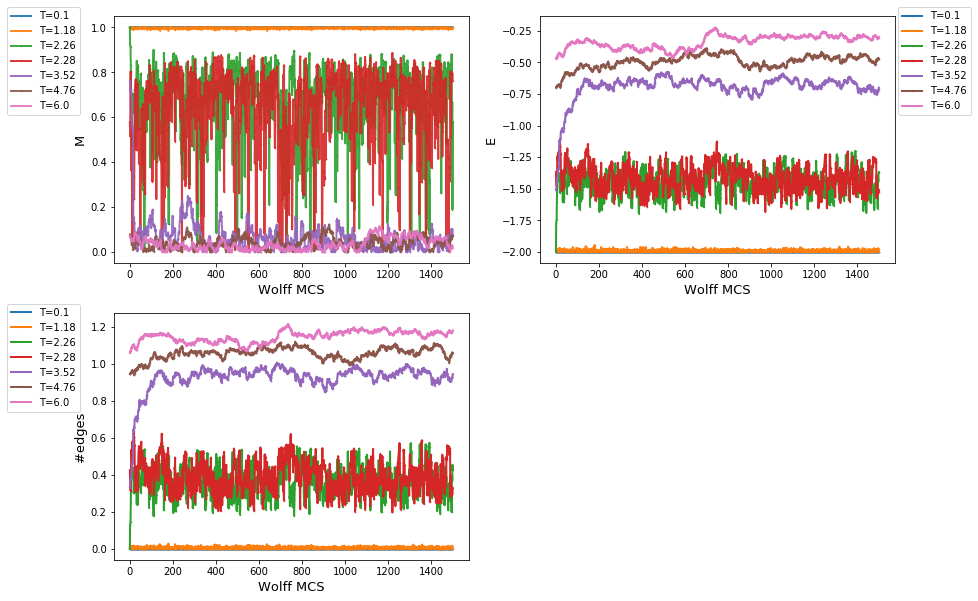

In [43]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3)
save = False

if not save:
    EqData = pickle.load(open('2DeqData.p', 'rb'))
    t_sim = EqData['t_sim']; N = EqData['N']; mag_data = EqData['mag_data']; en_data = EqData['en_data'] 
    NEGdata = EqData['NEGdata']
    
t = np.arange(t_sim)

for i, item in enumerate(temperatures):
    ax1.plot(t,mag_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,en_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1)
    ax3.plot(t,NEGdata[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('E', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('#edges', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6)); ax3.legend(loc=(-0.3,0.6))


if save:
    plt.savefig('2Dequitime')
    EqData = {'t_sim': t_sim, 'N': N, 'mag_data': mag_data, 'en_data': en_data, 'NEGdata': NEGdata}
    pickle.dump(EqData, open('2DeqData.p', 'wb'))

### Correlation function 

In [44]:
def corr_func_calc(x):
    ''' Calculated the correlation function of a data set (Magnetization/energy/specific heat/susceptibility)

        Parameters: 
            x: dtype numpy array or list
                One dimensional list or array containing the data
        
        Returns: dtype numpy array
            The correlation function'''
    
    t_max = len(x)
    c = np.zeros(t_max)
    for i in range(t_max):
        denom = t_max-i
        c[i] = (np.sum(x[:t_max-i]*x[i:t_max])/denom)-(np.sum(x[:t_max-i])*np.sum(x[i:t_max])/(denom**2))
    c = c/c[0]
    return(c)

In [45]:
def corr_time(corr, acc):
    ''' Automatically fits the correlation function to an exponention function and finds the decay length
        
        Parameters:
            corr: dtype numpy array
                The correlation function of a data set
            
        Returns: dtype float
            The decay length of the exponential fit'''
    
    l = 0; k = np.argmax(corr<0)-1
    corr_decay = np.log(corr[l:k])
    t = np.arange(t_prod)
    #print(len(t[l:k]),len(corr_decay))
    slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay)

    while r_val**2<acc:
        k -= 1
        slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay[:k])
    
    #return (slope, cep, r_val, err, t[l:k], corr_decay[:k])
    #plt.plot(t[l:k],corr_decay[:k])
    #plt.plot(t[l:k],cep+slope*t[l:k])
    #plt.show()
    tau = -1/slope
    return(tau)

In [46]:
def corr_and_error(x):
    corr = corr_func_calc(x)
    if (corr[0]==np.nan) or (np.argmax(corr<0)<3):
        tau = 0
        sigma = np.std(x)
    else: 
        tau = corr_time(corr, 0.98)
        sigma = np.sqrt(2*(tau/len(x))*np.std(x))                    
    return(corr, tau, sigma)
       

In [47]:
def plot_corr_shells(Lcorr_neg_data, Lcorr_nwe_data, Lidx, Tidx, step):
    L = possibleScales[Lidx]; nRGsteps, neg_baseline = number_of_RGsteps(L)
    temp = temperatures[Tidx]
    
    fig = plt.figure(figsize=(14,5)); plt.axis('off'); plt.title('L=%d, T=%.2f'%(N,temp))
    ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
    t = np.arange(len(Lcorr_neg_data[0][0][0]))
    
    for l in range(nRGsteps)[::step]:
        ax1.plot(t,Lcorr_neg_data[Lidx][Tidx][l], linewidth=2, label=('shell={}'.format(l)), alpha=0.9)
        ax2.plot(t, Lcorr_nwe_data[Lidx][Tidx][l], label=('shell={}'.format(l)))
    
    ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('Corr_neg', fontsize=13)
    ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('Corr_nwe', fontsize=13)
    ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63))


Set temperatures:

In [48]:
lowRange = np.linspace(0.01, 1, 4); midlowRange = np.linspace(1.2, 2, 7)
clowRange = 2.27 - np.geomspace(0.009, 0.16, 6); chighRange = 2.26 + np.geomspace(0.009, 0.7, 9)
midhighRange = np.linspace(3.3, 5, 5); highRange = np.linspace(5.7, 8, 4)

temperatures = np.sort(np.concatenate((lowRange,midlowRange, clowRange, chighRange, midhighRange, highRange)))
print(len(temperatures))
print(temperatures[:])

new = False
if new:
    possibleScales = []
    LcorrEdata = []; LtauEdata = []
    LcorrMdata = []; LtauMdata = []
    LcorrNEGdata = []; LtauNEGdata = []
    LcorrEnw_data = []; LtauEnw_data = []
    Lcorr_neg_data = []; Ltau_neg_data = []
    Lcorr_nwe_data = []; Ltau_nwe_data = []
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                   'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'LcorrNEGdata': LcorrNEGdata,
                   'LtauNEGdata': LtauNEGdata, 'LcorrEnw_data': LcorrEnw_data, 'LtauEnw_data': LtauEnw_data,
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data,
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

35
[0.01       0.34       0.67       1.         1.2        1.33333333
 1.46666667 1.6        1.73333333 1.86666667 2.         2.11
 2.18002031 2.21939785 2.24154271 2.25399639 2.261      2.269
 2.27550956 2.28672738 2.30605888 2.33937254 2.39678145 2.49571334
 2.6662011  2.96       3.3        3.725      4.15       4.575
 5.         5.7        6.46666667 7.23333333 8.        ]


In [49]:
run = False

if run:
    #run = False
    # Set system parameters (note that these are global!):
    N = 32
    t_eq = 1000
    t_prod = 500
    t_sim = t_eq + t_prod
    
    nRGsteps, neg_baseline = number_of_RGsteps(N)
    
    corrEdata = []; tauEdata = np.zeros(len(temperatures)) 
    corrMdata = []; tauMdata = np.zeros(len(temperatures)) 
    
    corrNEGdata = []; tauNEGdata = np.zeros(len(temperatures))
    corrEnw_data = []; tauEnw_data = np.zeros(len(temperatures))
    corr_neg_data = []; tau_neg_data = np.zeros((len(temperatures),nRGsteps))
    corr_nwe_data = []; tau_nwe_data = np.zeros((len(temperatures),nRGsteps))
    
    # Initial lattice configuration  
    lattice = -1*np.ones((N,N))  
    #lattice = np.random.choice([1,-1],size=(N))
    
    for j,T in enumerate(temperatures):
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
        
        #if 2.25<T and T<2.29:
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, NEG, Enw, neg, nwe = simulate_eff(lattice)
        clear_output(wait=True)
        
        lattice = np.copy(C[-1])
                        
        corrE, tauE, sigmaE = corr_and_error(E[t_eq:])
        corrM, tauM, sigmaM = corr_and_error(abs(M[t_eq:]))
        corrNEG, tauNEG, sigmaNEG = corr_and_error(NEG[t_eq:])
        corrEnw, tauEnw, sigmaEnw = corr_and_error(Enw[t_eq:])
            
        #if tauE > 198:
            #print('fail')
            #print(T)
            #print(tauE)
            #run = True
            #break
        '''else:
            corrEnw = np.zeros(t_prod); tauEnw = np.nan; sigmaEnw = np.nan
            corrEnw[:] = np.nan
            corrM = np.zeros(t_prod); tauM = np.nan; sigmaM = np.nan
            corrM[:] = np.nan
        '''
        
        corrEdata.append(corrE); tauEdata[j] = tauE
        corrMdata.append(corrM); tauMdata[j] = tauM  
        corrNEGdata.append(corrNEG); tauNEGdata[j] = tauNEG
        corrEnw_data.append(corrEnw); tauEnw_data[j] = tauEnw
        
        corr_neg = []; tau_neg = np.zeros(nRGsteps)
        corr_nwe = []; tau_nwe = np.zeros(nRGsteps)
        for l in range(nRGsteps):
            corr_neg_l, tau_neg_l, sigma_neg_l = corr_and_error(neg[t_eq:,l])
            corr_nwe_l, tau_nwe_l, sigma_nwe_l = corr_and_error(nwe[t_eq:,l])
            corr_neg.append(corr_neg_l); tau_neg[l] = tau_neg_l
            corr_nwe.append(corr_nwe_l); tau_nwe[l] = tau_nwe_l
            
        corr_neg_data.append(corr_neg); tau_neg_data[j] = tau_neg
        corr_nwe_data.append(corr_nwe); tau_nwe_data[j] = tau_nwe

idx = 0

LcorrEdata[idx] = corrEdata; LtauEdata[idx] = tauEdata LcorrNEGdata[idx] = corrNEGdata; LtauNEGdata[idx] = tauNEGdata LcorrEnw_data[idx] = corrEnw_data; LtauEnw_data[idx] = tauEnw_data Lcorr_neg_data[idx] = corr_neg_data; Ltau_neg_data[idx] = tau_neg_data Lcorr_nwe_data[idx] = corr_nwe_data; Ltau_nwe_data[idx] = tau_nwe_data

#LcorrMdata[idx] = corrMdata; LtauMdata[idx] = tauMdata

CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'LcorrNEGdata': LcorrNEGdata, 'LtauNEGdata': LtauNEGdata, 'LcorrEnw_data': LcorrEnw_data, 'LtauEnw_data': LtauEnw_data, 'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data, 'Ltau_nwe_data': Ltau_nwe_data} pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

In [51]:
CorrData = pickle.load(open('2DcorrData.p', 'rb'))
possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
LcorrNEGdata = CorrData['LcorrNEGdata']; LtauNEGdata = CorrData['LtauNEGdata']
LcorrEnw_data = CorrData['LcorrEnw_data']; LtauEnw_data = CorrData['LtauEnw_data']
Lcorr_neg_data = CorrData['Lcorr_neg_data']; Ltau_neg_data = CorrData['Ltau_neg_data']
Lcorr_nwe_data = CorrData['Lcorr_nwe_data']; Ltau_nwe_data = CorrData['Ltau_nwe_data']

save = False
if save:
    possibleScales.append(N)
    LcorrEdata.append(corrEdata); LtauEdata.append(tauEdata)
    LcorrMdata.append(corrMdata); LtauMdata.append(tauMdata)
    LcorrNEGdata.append(corrNEGdata); LtauNEGdata.append(tauNEGdata)
    LcorrEnw_data.append(corrEnw_data); LtauEnw_data.append(tauEnw_data)
    Lcorr_neg_data.append(corr_neg_data); Ltau_neg_data.append(tau_neg_data)
    Lcorr_nwe_data.append(corr_nwe_data); Ltau_nwe_data.append(tau_nwe_data)
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                   'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'LcorrNEGdata': LcorrNEGdata,
                   'LtauNEGdata': LtauNEGdata, 'LcorrEnw_data': LcorrEnw_data, 'LtauEnw_data': LtauEnw_data,
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data,
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

In [52]:
save = False

if not save:
    CorrData = pickle.load(open('2DcorrData.p', 'rb'))
    possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
    LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
    LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
    Lcorr_neg_data = CorrData['Lcorr_neg_data']; Ltau_neg_data = CorrData['Ltau_neg_data']
    Lcorr_nwe_data = CorrData['Lcorr_nwe_data']; Ltau_nwe_data = CorrData['Ltau_nwe_data']

tauData = [['','MAXtauE', 'MAXtauM', 'MAXtauNEG', 'MAXtauEnw']]

for i,L in enumerate(possibleScales):
    row = []
    tauE = round(np.nanmax(LtauEdata[i]),3); tauM = round(np.nanmax(LtauMdata[i]),3)
    tauNEG = round(np.nanmax(LtauNEGdata[i]),3); tauEnw = round(np.nanmax(LtauEnw_data[i]),3)
    j = np.nanargmax(LtauEdata[i]); k = np.nanargmax(LtauMdata[i])
    m = np.nanargmax(LtauNEGdata[i]); n = np.nanargmax(LtauEnw_data[i])
    T1 = temperatures[j]; T2 = temperatures[k]; T3 = temperatures[m]; T4 = temperatures[n]
    row.append('L = %d'%(L)); row.append('%.1f (T=%.2f)'%(tauE,T1)); row.append('%.1f (T=%.2f)'%(tauM,T2))
    row.append('%.1f (T=%.2f)'%(tauNEG,T3)); row.append('%.1f (T=%.2f)'%(tauEnw,T4))
    tauData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tauData))))

tau_negData = [['','MAXtau_neg0', 'MAXtau_neg1', 'Maxtau_neg2', 'etc']]

for i,L in enumerate(possibleScales):
    row = []; row.append('L = %d'%(L));
    tau_neg_ls = np.nanmax(Ltau_neg_data[i],axis=0); qs = np.nanargmax(Ltau_neg_data[i],axis=0)
    for tau_neg_l,q in zip(tau_neg_ls,qs):
        T5 = temperatures[q]; row.append('%.1f (T=%.2f)'%(tau_neg_l,T5))
    tau_negData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tau_negData))))

tau_nweData = [['','MAXtau_nwe0', 'MAXtau_nwe1', 'Maxtau_nwe2', 'etc']]

for i,L in enumerate(possibleScales):
    row = []; row.append('L = %d'%(L));
    tau_nwe_ls = np.nanmax(Ltau_nwe_data[i],axis=0); rs = np.nanargmax(Ltau_nwe_data[i],axis=0)
    for tau_nwe_l,r in zip(tau_nwe_ls,rs):
        T6 = temperatures[r]; row.append('%.1f (T=%.2f)'%(tau_nwe_l,T6))
    tau_nweData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tau_nweData))))
    
if save:
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                   'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data, 
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

,MAXtauE,MAXtauM,MAXtauNEG,MAXtauEnw
L = 8,11.3 (T=5.70),6.5 (T=8.00),9.8 (T=4.58),9.8 (T=4.58)
L = 16,41.2 (T=6.47),21.3 (T=7.23),47.5 (T=8.00),47.5 (T=8.00)
L = 32,179.2 (T=5.70),43.0 (T=5.00),160.8 (T=5.70),160.8 (T=5.70)


L = 32


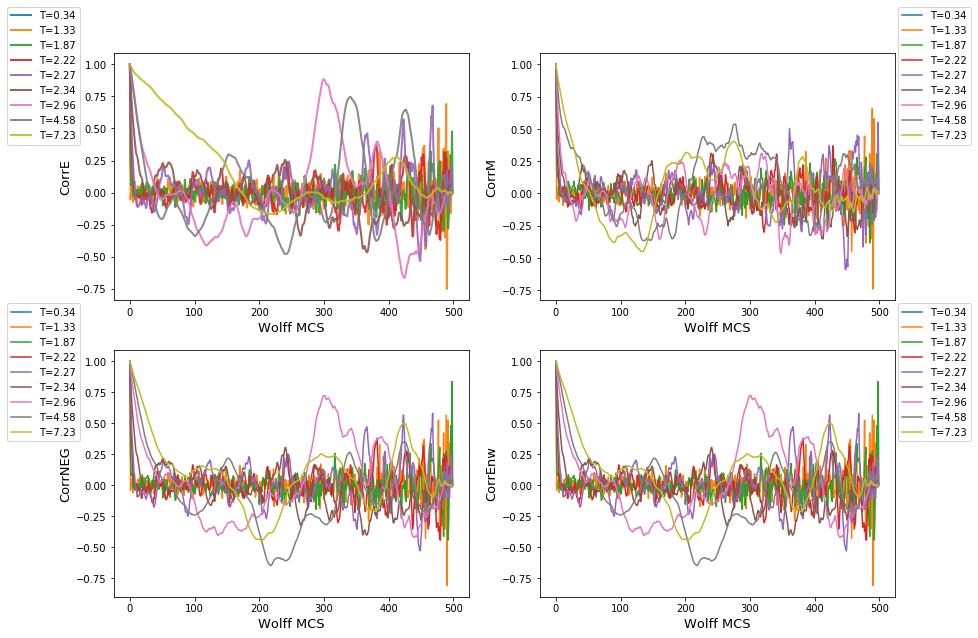

In [53]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3); ax4 = fig.add_subplot(2,2,4)
t = np.arange(len(LcorrEdata[0][0]))
i = 2 # index of scales
l = 1; k = 34
step = 4

for j, item in enumerate(temperatures[l::step]):
    ax1.plot(t,LcorrEdata[i][j*step+l], linewidth=2, label=('T={}'.format(np.around(item,2))), alpha=0.9)
    ax2.plot(t, LcorrMdata[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    ax3.plot(t, LcorrNEGdata[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    ax4.plot(t, LcorrEnw_data[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('CorrE', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('CorrM', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('CorrNEG', fontsize=13)
ax4.set_xlabel('Wolff MCS',fontsize=13); ax4.set_ylabel('CorrEnw', fontsize=13)
ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63)); ax3.legend(loc=(-0.3,0.63)); ax4.legend(loc=(1.01,0.63))

print('L = %d'%(possibleScales[i]))
#print('Correlation time (decay length) of the energy(nng):', LtauEnw[i])
#print('Correlation time (decay length) of the magnetization:', LtauM[i])


In [54]:
%matplotlib inline
wg.interact(plot_corr_shells, Lcorr_neg_data=wg.fixed(Lcorr_neg_data), Lcorr_nwe_data=wg.fixed(Lcorr_nwe_data), 
            Lidx=(0,len(possibleScales)-1), Tidx=(0,len(temperatures)-1), step=(1,4))

interactive(children=(IntSlider(value=1, description='Lidx', max=2), IntSlider(value=17, description='Tidx', m…

<function __main__.plot_corr_shells(Lcorr_neg_data, Lcorr_nwe_data, Lidx, Tidx, step)>

### Average energy

In [55]:
scales = [8, 16, 32]
print(scales)
print(len(temperatures))
print(temperatures)

[8, 16, 32]
35
[0.01       0.34       0.67       1.         1.2        1.33333333
 1.46666667 1.6        1.73333333 1.86666667 2.         2.11
 2.18002031 2.21939785 2.24154271 2.25399639 2.261      2.269
 2.27550956 2.28672738 2.30605888 2.33937254 2.39678145 2.49571334
 2.6662011  2.96       3.3        3.725      4.15       4.575
 5.         5.7        6.46666667 7.23333333 8.        ]


In [58]:
# Set system parameters (note that these are global!):
#scales = [8, 16, 32] # Lattice number
#temperatures = np.linspace(0.1, 8, 30) # Temperature (critical at around 2.27)
#temperatures = np.sort(np.random.normal(2.28,0.6,3))# Temperature (critical at around 2.27)

run =  False
if run:
    Len_data = []; Len_err = []#; LtausE = []
    Lmag_data = []; Lmag_err = []
    L_NEGdata = []; L_NEGerr = []
    Len_nw_data = []; Len_nw_err = []
    Lneg_data = []; Lneg_err = []#; Ltaus_neg = []
    Lnwe_data = []; Lnwe_err = []
    L_CvEdata = []; L_CvNEGdata = []; L_CvEnw_data = []; L_Cv_neg_data = []; L_Cv_nwe_data = []
    Lsusc_data = []

    for N in scales:
        t_eq = 1000
        t_prod = 25000
        t_sim = t_eq + t_prod
    
        nRGsteps, neg_baseline = number_of_RGsteps(N)
    
        en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))#; tausE = []
        mag_data = np.zeros(len(temperatures)); mag_err = np.zeros(len(temperatures))
        NEGdata = np.zeros(len(temperatures)); NEGerr = np.zeros(len(temperatures))
        en_nw_data = np.zeros(len(temperatures)); en_nw_err = np.zeros(len(temperatures))
        neg_data = np.zeros((len(temperatures),nRGsteps)); neg_err = np.zeros((len(temperatures),nRGsteps))
        nwe_data = np.zeros((len(temperatures),nRGsteps)); nwe_err = np.zeros((len(temperatures),nRGsteps))
    
        CvEdata = np.zeros(len(temperatures)); CvNEGdata = np.zeros(len(temperatures)); CvEnw_data = np.zeros(len(temperatures))
        Cv_neg_data = np.zeros((len(temperatures),nRGsteps)); Cv_nwe_data = np.zeros((len(temperatures),nRGsteps))
        susc_data = np.zeros(len(temperatures))
    
        # Initial lattice configuration
        lattice = -1*np.ones((N,N))  
        # lattice = np.random.choice([1,-1],size=(N,N))
  
        for j,T in enumerate(temperatures):
            #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
            # (only need first two values for metropolis)
            A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
            print('Performing simulation with T = ', T, 'and N = ', N)
            C, E, M, NEG, Enw, neg, nwe = simulate_eff(lattice)
            clear_output(wait=True)
    
            lattice = C[-1]
    
            en_data[j] = np.mean(E[t_eq:]); en_err[j] = np.std(E[t_eq:])#; tausE[j] = tauE
            mag_data[j] = np.mean(abs(M[t_eq:])); mag_err[j] = np.std(abs(M[t_eq:]))
            NEGdata[j] = np.mean(NEG[t_eq:]); NEGerr[j] = np.std(NEG[t_eq:])
            en_nw_data[j] = np.mean(Enw[t_eq:]); en_nw_err[j] = np.std(Enw[t_eq:])
            neg_data[j] = np.mean(neg[t_eq:], axis=0); neg_err[j] = np.std(neg[t_eq:], axis=0)
            nwe_data[j] = np.mean(nwe[t_eq:], axis=0); nwe_err[j] = np.std(nwe[t_eq:], axis=0)
    
            CvEdata[j] = specific_heat(E[t_eq:]); CvNEGdata[j] = specific_heat(NEG[t_eq:])
            CvEnw_data[j] = specific_heat(Enw[t_eq:]); Cv_neg_data[j] = specific_heat(neg[t_eq:])
            Cv_nwe_data[j] = specific_heat(nwe[t_eq:])
            susc_data[j] = susceptiblity(abs(M[t_eq:]))
    
        Len_data.append(en_data); Len_err.append(en_err)#; LtausE.append(tausE)
        Lmag_data.append(mag_data); Lmag_err.append(mag_err)
        L_NEGdata.append(NEGdata); L_NEGerr.append(NEGerr)
        Len_nw_data.append(en_nw_data); Len_nw_err.append(en_nw_err)
        Lneg_data.append(neg_data); Lneg_err.append(neg_err)#; Ltaus_neg.append(taus_neg)
        Lnwe_data.append(nwe_data); Lnwe_err.append(nwe_err)
        L_CvEdata.append(CvEdata); L_CvNEGdata.append(CvNEGdata); L_CvEnw_data.append(CvEnw_data) 
        L_Cv_neg_data.append(Cv_neg_data); L_Cv_nwe_data.append(Cv_nwe_data)
        Lsusc_data.append(susc_data)
    
else:
    Ldata = pickle.load(open('2Dfinite_size_scaling_data.p', 'rb'))
    Len_data = Ldata['Len_data']; Len_err = Ldata['Len_err']; L_CvEdata = Ldata['L_CvEdata']
    L_NEGdata = Ldata['L_NEGdata']; L_NEGerr = Ldata['L_NEGerr']; L_CvNEGdata = Ldata['L_CvNEGdata']
    Len_nw_data = Ldata['Len_nw_data']; Len_nw_err = Ldata['Len_nw_err']; L_CvEnw_data = Ldata['L_CvEnw_data']
    Lneg_data = Ldata['Lneg_data']; Lneg_err = Ldata['Lneg_err']; L_Cv_neg_data = Ldata['L_Cv_neg_data']
    Lnwe_data = Ldata['Lnwe_data']; Lnwe_err = Ldata['Lnwe_err']; L_Cv_nwe_data = Ldata['L_Cv_nwe_data']
    temperatures = Ldata['temperatures']; scales = Ldata['scales']

    Ldata_mag = pickle.load(open('2Dfinite_size_scaling_data_mag.p', 'rb'))
    Lmag_data= Ldata_mag['Lmag_data']; Lmag_err = Ldata_mag['Lmag_err']; Lsusc_data = Ldata_mag['Lsusc_data']

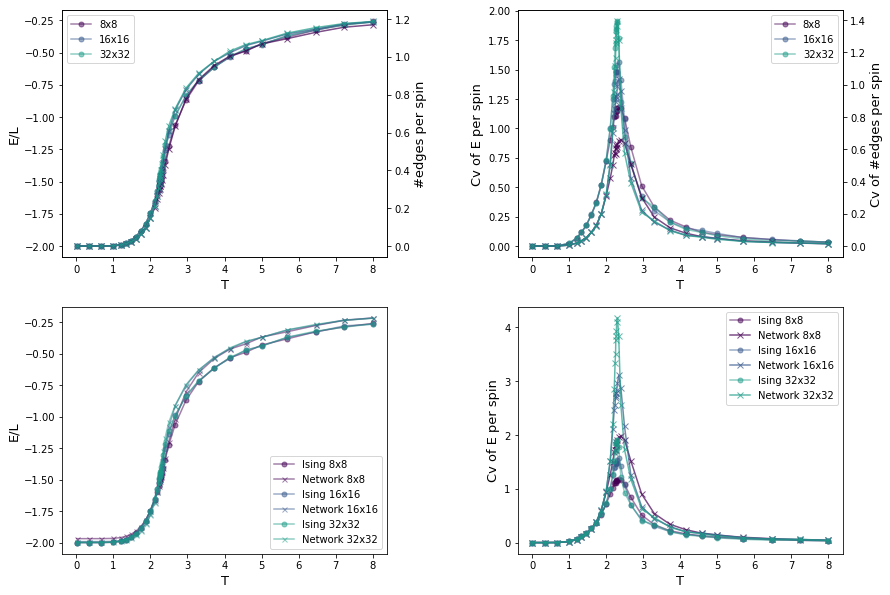

In [59]:
# Energy ~ Number of Edges
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,10))
fig4.subplots_adjust(wspace=0.4)
# energy:
ax41 = fig4.add_subplot(2,2,1); ax42 = ax41.twinx()
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('E/L', fontsize=13)#, color='y')
ax42.set_ylabel('#edges per spin', fontsize=13)#, color='r')
# specific heat:
ax43 = fig4.add_subplot(2,2,2); ax44 =ax43.twinx()
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('Cv of E per spin', fontsize=13)
ax44.set_ylabel('Cv of #edges per spin', fontsize=13)
# energy:
ax45 = fig4.add_subplot(2,2,3)
ax45.set_xlabel('T',fontsize=13)
ax45.set_ylabel('E/L', fontsize=13)#, color='y')
# specific heat:
ax46 = fig4.add_subplot(2,2,4)
ax46.set_xlabel('T',fontsize=13)
ax46.set_ylabel('Cv of E per spin', fontsize=13)

geom=4/3

for i,L in enumerate(scales):
    NEGdata = np.sum(Lneg_data[i], axis=1)
    # energy:
    ax41.plot(temperatures, Len_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%dx%d'%(L,L), color=cm.viridis(i*70))
    #ax41.errorbar(temperatures, Len_data[i], yerr=Len_err[i], alpha=0.3, linestyle='', color=cm.viridis(i*70))
    ax42.plot(temperatures, L_NEGdata[i]/(L**2), marker='x',markersize=6, alpha=0.7, label='%dx%d'%(L,L), color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lneg_data[i]/L, yerr=Lneg_err[i]/L, linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # specific heat:
    ax43.plot(temperatures, L_CvEdata[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%dx%d'%(L,L), 
              color=cm.viridis(i*70))
    ax44.plot(temperatures, L_CvNEGdata[i]/(L**2), marker='x', markersize=6, alpha=0.7, label='%dx%d'%(L,L), 
              color=cm.viridis(i*70))
    # energy:
    ax45.plot(temperatures, Len_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='Ising %dx%d'%(L,L), 
              color=cm.viridis(i*70))
    ax45.plot(temperatures, Len_nw_data[i]/(geom*(L**2)), marker='x', markersize=5, alpha=0.5, label='Network %dx%d'%(L,L), 
              color=cm.viridis(i*70))
    # specific heat:
    ax46.plot(temperatures, L_CvEdata[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='Ising %dx%d'%(L,L), 
              color=cm.viridis(i*70))
    ax46.plot(temperatures, L_CvEnw_data[i]/(geom*(L**2)), marker='x', markersize=6, alpha=0.7, label='Network %dx%d'%(L,L), 
              color=cm.viridis(i*70))
    
ax41.legend(); ax43.legend(); ax45.legend(); ax46.legend()

if save:
    # Save data as dictionary:
    Ldata = {'Len_data': Len_data, 'Len_err': Len_err, 'L_CvEdata': L_CvEdata, 'L_NEGdata': L_NEGdata, 'L_NEGerr': L_NEGerr,
             'L_CvNEGdata': L_CvNEGdata, 'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data,
             'Lneg_data': Lneg_data, 'Lneg_err': Lneg_err, 'Lnwe_data': Lnwe_data, 'Lnwe_err': Lnwe_err, 
             'L_Cv_neg_data': L_Cv_neg_data, 'L_Cv_nwe_data': L_Cv_nwe_data, 'temperatures': temperatures, 'scales': scales, 
             't_prod': t_prod}
    pickle.dump(Ldata, open('2Dfinite_size_scaling_data.p', 'wb'))

32


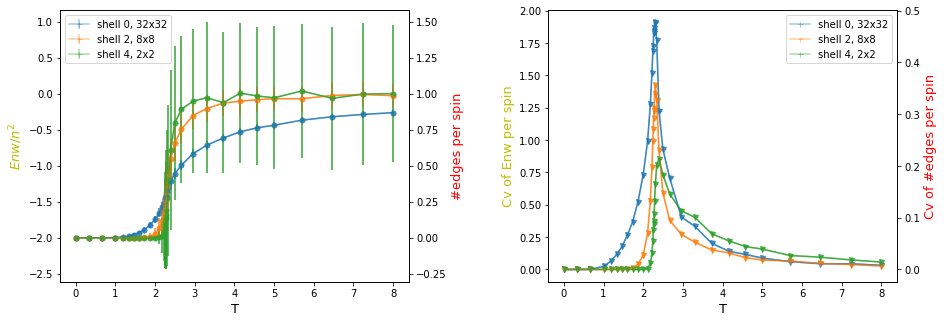

In [60]:
# edges in inner shells
%matplotlib inline

Lidx  = 2 # scale index
L = scales[Lidx]
nRGsteps = len(Lneg_data[Lidx][0,:])
step = 2
print(L)

fig1 = plt.figure(figsize=(15,5))
ax11 = fig1.add_subplot(1,2,1); ax12 = ax11.twinx()
ax13 = fig1.add_subplot(1,2,2); ax14 = ax13.twinx()
fig1.subplots_adjust(wspace=0.4)

for i in range(nRGsteps)[::step]:
    l = np.arange(nRGsteps)
    n_l = L/(2**l)
    ax11.errorbar(temperatures, Lnwe_data[Lidx][:,i]/(n_l[i]**2), marker='o', yerr=Lnwe_err[Lidx][:,i]/(n_l[i]**2), 
                  label='shell %d, %dx%d'%(i,n_l[i],n_l[i]), markersize=5, alpha=0.8)
    ax11.set_xlabel('T',fontsize=13)
    ax11.set_ylabel('$Enw/n^2$', fontsize=13, color='y')
    
    ax12.errorbar(temperatures, Lneg_data[Lidx][:,i]/(n_l[i]**2), yerr=Lneg_err[Lidx][:,i]/(n_l[i]**2), 
                  label='shell %d, %dx%d'%(i,n_l[i],n_l[i]), marker='+', markersize=5, alpha=0.4)
    ax12.set_ylabel('#edges per spin', fontsize=13, color='r')
    
    ax13.plot(temperatures, L_Cv_nwe_data[Lidx][:,i]/(n_l[i]**2), marker='v', markersize=5, alpha=0.8)
    ax13.set_xlabel('T',fontsize=13)
    ax13.set_ylabel('Cv of Enw per spin', fontsize=13, color='y')

    ax14.plot(temperatures, L_Cv_neg_data[Lidx][:,i]/(n_l[i]**2), label='shell %d, %dx%d'%(i,n_l[i],n_l[i]), marker='+', 
              markersize=5, alpha=0.4)
    ax14.set_ylabel('Cv of #edges per spin', fontsize=13, color='r')

    
ax12.legend(loc='upper left')
ax14.legend()

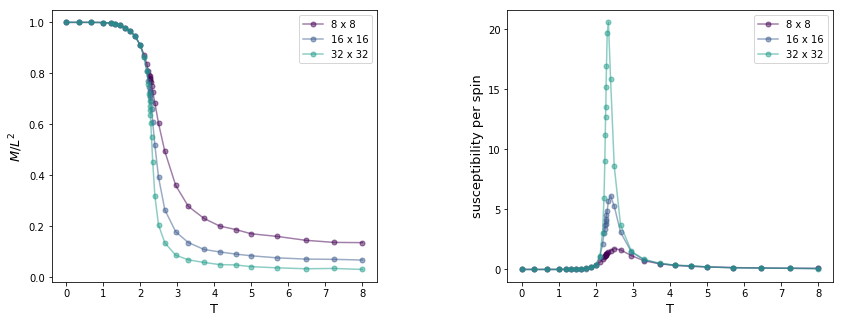

In [61]:
# magnetization ~ susceptibility
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5))
fig4.subplots_adjust(wspace=0.4)
# magnetization:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$M/L^2$', fontsize=13)#, color='y')

# susceptibility:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('susceptibility per spin', fontsize=13)

for i,L in enumerate(scales):
    # magnetization:
    ax41.plot(temperatures, Lmag_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    #ax41.errorbar(temperatures, Len_data[i], yerr=Len_err[i], alpha=0.3, linestyle='', color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lnng_data[i], yerr=Lnng_err[i], linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # susceptibility:
    ax43.plot(temperatures, Lsusc_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    Ldata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata_mag, open('2Dfinite_size_scaling_data_mag.p', 'wb'))

# Free energy 

In [62]:
def exc_free_energy_calc():
    f = np.zeros(len(temperatures))
    def integrand(phi, k):
        return np.log((1+np.sqrt(1-(k*np.sin(phi))**2))/2)
    for i,T in enumerate(temperatures):
        a = -T*np.log(2*np.cosh(2/T))
        k = 2*np.sinh(2/T)/(np.cosh(2/T)**2)
        I = integrate.quad(integrand, 0, np.pi, args=(k))
        b = -(T/(2*np.pi))*I[0]
        f[i] = a+b
    return f

In [63]:
def create_energy_hist(x, mode):
    lowB = np.min(x)
    upperB = np.max(x)
    n = round(abs(upperB-lowB)*100)+2
    if mode == 'nw':
        n = round(abs(upperB-lowB)*100)+2
    print(n)
    bin_edges = np.linspace(lowB,upperB,n)
    #bin_edges = np.histogram_bin_edges(en, bins='doane')
    #h, b = stats.histogram(en, bins='blocks')
    h, b = np.histogram(x, bins=bin_edges)#, density=True)
    idx = np.where(h>0)
    h = h[idx]
    b = b[idx]
    return h, b
    

In [64]:
def free_energy_calc(nE, en, g, temp):
    nE = Decimal(nE); g = Decimal(g); en = Decimal(en);  temp = Decimal(temp)
    ln = Decimal(g).ln() - Decimal(nE).ln() # equivalent to ln(g/nE)
    f = -temp*ln + en
    return f

In [65]:
def g_transfer(nE1, en1, g1, nE2, en2, temp):
    nE1 = Decimal(nE1); en1 = Decimal(en1); g1 = Decimal(g1); nE2 = Decimal(nE2); en2 = Decimal(en2); temp = Decimal(temp)
    boltz_exp = np.exp(-(1/temp)*(en1-en2))
    #print('bExp', boltz_exp)
    g2 = round(g1*(nE2/nE1)*boltz_exp)
    return g2

In [66]:
def find_intersection(x_targ, y_targ, x2, y2):
    m = len(x_targ)
    n = len(x2)
    min_dist = 10000
    coords = np.zeros((2,2))
    for i in range(m):
        for j in range(n):
            d = (x2[j]-x_targ[i])**2 + (y2[j]-y_targ[i])**2
            if d < min_dist:
                min_dist = d
                coords[0][0] = x_targ[i]
                coords[0][1] = y_targ[i]
                coords[1][0] = x2[j]
                coords[1][1] = y2[j]
    return(coords)


In [67]:
def free_energyVStemp(hists, bins, g0):
    f = np.zeros(len(temperatures))
    idx = np.argmax(hists[0])
    nE = hists[0][idx]
    en = bins[0][idx]
    g = g0
    
    for i,temperature in enumerate(temperatures):
        #print('g',g)
        #print('nE', nE)
        f[i] = free_energy_calc(nE, en, g, temperature)   
        
        if i == (len(temperatures)-1):
            break
        #print(i)
        hist1 = hists[i]
        bins1 = bins[i]
        hist2 = hists[i+1]
        bins2 = bins[i+1]
        l = np.argmax(hist1)
        k = np.argmax(hist2)+1
        #print('l:', l, 'k:', k)
        if bins2[k-1] < bins1[l]:
            raise ValueError('Data of consecutive histograms %d and %d are not consecutive'%(i,i+1))
          
        # get intersection
        coords = find_intersection(bins1[l:], hist1[l:], bins2[:k], hist2[:k])
        
        en1 = coords[0][0]
        nE1 = coords[0][1]
               
        g = g_transfer(nE, en, g, nE1, en1, temperature)
        #print(coords)
        en = coords[1][0]
        nE = coords[1][1]  
    return f
            

In [68]:
def check_visual(i, hists, bins):

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    
    b1 = bins[i]
    h1 = hists[i]
    l = np.argmax(h1)
    temperature1 = temperatures[i]
    
    b2 = bins[i+1]
    h2 = hists[i+1]
    k = np.argmax(h2)+1
    temperature2 = temperatures[i+1]
    
    ax.plot(b1/(N**2), h1,label='T=%.2f'%(temperature1), markersize=3, linestyle='-', marker='o', linewidth=1, color='#1f77b4')
    ax.plot(b1[l:]/(N**2), h1[l:], markersize=6, color='#1f77b4', marker='o', linewidth=2)
    
    ax.plot(b2/(N**2), h2,label='T=%.2f'%(temperature2), markersize=3, linestyle='-', marker='o', linewidth=1, color='orange')
    ax.plot(b2[:k]/(N**2), h2[:k], markersize=6, color='orange', marker='o', linewidth=2)
    
    ax.legend()
    #ax5.set_yscale('log')

### Free Energy Simulation

In [69]:
lowRange = np.linspace(0.01, 1.2, 4); midlowRange = np.linspace(1.4, 1.97, 6)
crRange = np.arange(2.085, 2.5, 0.095)
midhighRange = np.linspace(2.6, 3.3, 5); highRange = np.geomspace(3.6, 6, 5)
temperatures = np.sort(np.concatenate((lowRange,midlowRange, crRange, midhighRange, highRange)))
print(len(temperatures))
print(temperatures[:])
print(np.diff(temperatures))

f_exact = exc_free_energy_calc()

new = False
if new:
    scales = []
    Len_data = []#; Len_err = []
    Len_hist_data = []; Len_bin_edges_data = []
    Len_fr = []; LenS = []
    
    # Save data as dictionary:
    Lf_data = {'f_exact': f_exact, 'Len_fr': Len_fr, 'LenS': LenS, 'Len_data': Len_data, 
                  'Len_err': Len_err, 'Len_hist_data': Len_hist_data, 
                  'Len_bin_edges_data': Len_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(Lf_data, open('2Dfree_energy_finite_size_scaling.p', 'wb'))

25
[0.01       0.40666667 0.80333333 1.2        1.4        1.514
 1.628      1.742      1.856      1.97       2.085      2.18
 2.275      2.37       2.465      2.6        2.775      2.95
 3.125      3.3        3.6        4.09038972 4.64758002 5.28067042
 6.        ]
[0.39666667 0.39666667 0.39666667 0.2        0.114      0.114
 0.114      0.114      0.114      0.115      0.095      0.095
 0.095      0.095      0.135      0.175      0.175      0.175
 0.175      0.3        0.49038972 0.5571903  0.63309041 0.71932958]


In [70]:
# Set system parameters (note that these are global!):
#low_range = np.linspace(0.1, 3, 20); high_range = np.linspace(3.5, 6, 5)
#temperatures = np.concatenate((low_range, high_range))
#temperatures = np.linspace(0.1, 5, 25) # Temperature (critical at around 2.27)

run = False

if run:
    N = 32
    t_eq = 1000
    t_prod = 40000
    t_sim = t_eq + t_prod
    
    en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))
    en_hist_data = []; en_bin_edges_data = []

    # Initial lattice configuration
    lattice = -1*np.ones((N,N))  
    # lattice = np.random.choice([1,-1],size=(N,N))
  
    for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        #probability (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, NEG, Enw, neg, nwe = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        
        en_hist, en_bin_edges = create_energy_hist(E[t_eq:], 'en')
        
        en_data[j] = np.mean(E[t_eq:])#; en_err[j] = np.std(E[t_eq::snap])
        
        en_hist_data.append(en_hist/t_prod); en_bin_edges_data.append(en_bin_edges)
        

### Visually check histograms 

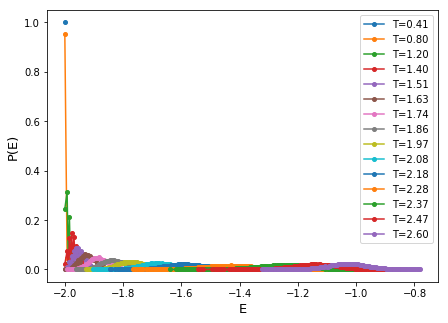

In [55]:
%matplotlib inline
fig5 = plt.figure(figsize=(7,5))
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xlabel('E', fontsize=13)
ax5.set_ylabel('P(E)', fontsize=13)

l = 1
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax5.plot(en_bin_edges_data[l+i]/(N**2), en_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax5.legend()
#ax5.set_yscale('log')

In [56]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(en_hist_data), bins=wg.fixed(en_bin_edges_data), i=(0,len(temperatures)-2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

<function __main__.check_visual(i, hists, bins)>

### Plot free energy

In [57]:
#f_exact = exc_free_energy_calc()
en_fr = free_energyVStemp(en_hist_data, en_bin_edges_data, 2)
print(en_fr)

[-2048.00693147 -2048.28187985 -2048.59583825 -2050.51696687
 -2054.3388421  -2058.21422044 -2063.95934244 -2072.03590746
 -2082.98749372 -2097.64092928 -2116.93975313 -2137.46305607
 -2163.49823696 -2196.62136278 -2235.75186468 -2297.57258107
 -2384.78097271 -2478.67363397 -2576.81033355 -2678.60067942
 -2858.78611661 -3164.67849488 -3525.72999478 -3945.64858647
 -4430.71713545]


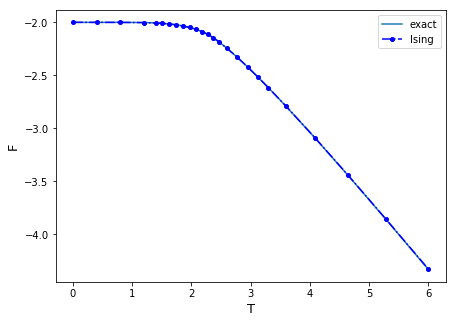

In [58]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1)#; ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('F', fontsize=13)

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_fr/(N**2), label='Ising', linestyle='-.', color='b', marker='o', markersize=4)

ax7.legend()

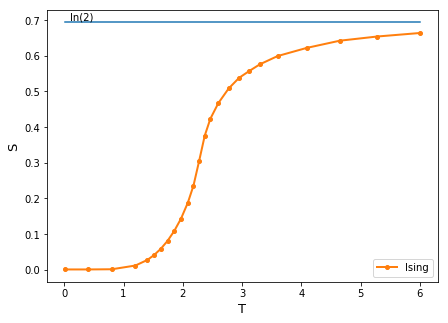

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('neg S', fontsize=13, color='g')

enS = (en_data-en_fr)/(temperatures)
ax.annotate('ln(2)', (0.1,0.7))
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)))
ax.plot(temperatures, enS/(N**2), label='Ising', linewidth=2, marker='o', markersize=4)

ax.legend()

In [72]:
Lf_data = pickle.load(open('2Dfree_energy_finite_size_scaling.p', 'rb'))
f_exact = Lf_data['f_exact']; Len_fr = Lf_data['Len_fr']; LenS = Lf_data['LenS'] 
Len_data = Lf_data['Len_data'] ; Len_err = Lf_data['Len_err'] 
Len_hist_data = Lf_data['Len_hist_data']; Len_bin_edges_data = Lf_data['Len_bin_edges_data']
temperatures = Lf_data['temperatures']; scales = Lf_data['scales']

save = False
if save:
    scales.append(N)
    Len_fr.append(en_fr); LenS.append(enS)
    Len_data.append(en_data); Len_err.append(en_err)
    Len_hist_data.append(en_hist_data); Len_bin_edges_data.append(en_bin_edges_data)
    
    # Save energy data as dictionary:
    Lf_data = {'f_exact': f_exact, 'Len_fr': Len_fr, 'LenS': LenS, 'Len_data': Len_data, 'Len_err': Len_err, 
               'Len_hist_data': Len_hist_data, 'Len_bin_edges_data': Len_bin_edges_data, 'temperatures': temperatures, 
               'scales': scales, 't_prod': t_prod}
    pickle.dump(Lf_data, open('2Dfree_energy_finite_size_scaling.p', 'wb'))
    

In [73]:
print(scales)

[8, 16, 32]


### Plot free energy for various system size

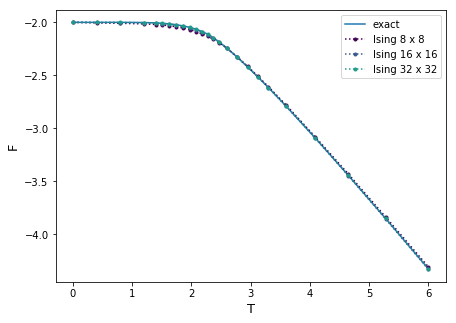

In [74]:
%matplotlib inline

fig8 = plt.figure(figsize=(7,5))
ax8 = fig8.add_subplot(1,1,1)#; ax9 = ax8.twinx()
ax8.set_xlabel('T', fontsize=13)
ax8.set_ylabel('F', fontsize=13)
#ax9.set_ylabel('neg F', fontsize=13)

ax8.plot(temperatures, f_exact, label='exact')

for i,L in enumerate(scales):
    ax8.plot(temperatures, Len_fr[i]/(L**2), label='Ising %d x %d'%(L,L), linestyle=':', color=cm.viridis(i*70), 
             marker='o', markersize=3)
    
ax8.legend()
#ax9.legend(loc='lower left')

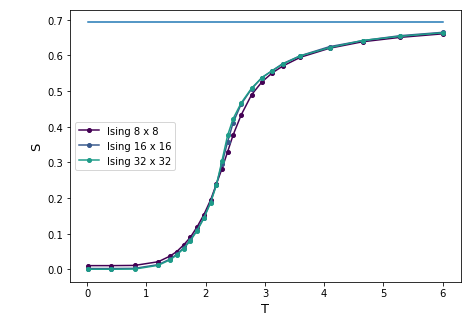

In [75]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('neg S', fontsize=13)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)))
ax.annotate('ln(2)', (0.3,0.8))

for i,L in enumerate(scales):
    ax.plot(temperatures, LenS[i]/(L**2), label='Ising %d x %d'%(L,L), color=cm.viridis(i*70), marker='o', markersize=4)
    
ax.legend(loc='center left')
#ax1.legend(loc='center right')